# Graded assignment 1 - text classification using Genetic Algorithms

In this assignmetn we'll make a binary text classifier using genetic algorithms. We will classify movie reviews from IMDB as either negative or positive. This task consists of several steps:

1. Preprocessing of the text
2. Genetich Algorithm
3. Validation



## 1. Preprocessing

### 1.1 Uploading data

In [1]:
## Upload the text
import numpy as np
import pandas as pd
import nltk
import string
import re
import math
import random
from scipy import special
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import PlaintextCorpusReader
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abdka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abdka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# File directories
corpus_train_pos_root = 'aclImdb/train/pos/'
corpus_train_neg_root = 'aclImdb/train/neg/'
corpus_test_pos_root = 'aclImdb/test/pos/'
corpus_test_neg_root = 'aclImdb/test/neg/'

# Corpus file objects
files_train_pos = PlaintextCorpusReader(corpus_train_pos_root, '.*')
files_train_neg = PlaintextCorpusReader(corpus_train_neg_root, '.*')
files_test_pos = PlaintextCorpusReader(corpus_test_pos_root, '.*')
files_test_neg = PlaintextCorpusReader(corpus_test_neg_root, '.*')


# Getting review texts, labels and rates all in arrays
reviews_train_pos = [files_train_pos.open(n).read() for n in files_train_pos.fileids()]
rates_train_pos = [int(re.split("_|\.", n)[-2]) for n in files_train_pos.fileids()]
labels_train_pos = [1] * len(reviews_train_pos)

reviews_train_neg = [files_train_neg.open(n).read() for n in files_train_neg.fileids()]
rates_train_neg = [int(re.split("_|\.", n)[-2]) for n in files_train_neg.fileids()]
labels_train_neg = [0] * len(reviews_train_neg)

reviews_test_pos = [files_test_pos.open(n).read() for n in files_test_pos.fileids()]
rates_test_pos = [int(re.split("_|\.", n)[-2]) for n in files_test_pos.fileids()]
labels_test_pos = [1] * len(reviews_test_pos)

reviews_test_neg = [files_test_neg.open(n).read() for n in files_test_neg.fileids()]
rates_test_neg = [int(re.split("_|\.", n)[-2]) for n in files_test_neg.fileids()]
labels_test_neg = [0] * len(reviews_test_neg)

### 1.2 Splitting data

In [3]:
# Putting all into two Pandas dataframes - training set and testing set
train_set = pd.DataFrame()
test_set = pd.DataFrame()
valid_set = pd.DataFrame()
whole_set = pd.DataFrame()


# Puttin all data into whole set
whole_set['review'] = reviews_train_pos + reviews_test_pos + reviews_train_neg + reviews_test_neg
whole_set['rate'] = rates_train_pos + rates_test_pos + rates_train_neg + rates_test_neg
whole_set['label'] = labels_train_pos + labels_test_pos + labels_train_neg + labels_test_neg

# Dividing reviews into negative and positive to make sure data is always balanced
negatives = whole_set.loc[whole_set['label'] == 0]
positives = whole_set.loc[whole_set['label'] == 1]

# Splitting positive and negative reviews
train_set, valid_set, test_set = np.split(positives, [int(0.7*len(positives)), int(0.85*len(positives))])
tr_neg, vl_neg, ts_neg = np.split(negatives, [int(0.7*len(negatives)), int(0.85*len(negatives))])

# Appending negatives to positives
train_set = train_set.append(tr_neg)
valid_set = valid_set.append(vl_neg)
test_set = test_set.append(ts_neg)

# Shuffle and reset the index
train_set = train_set.sample(frac=1).reset_index(drop=True)
valid_set = valid_set.sample(frac=1).reset_index(drop=True)
test_set = test_set.sample(frac=1).reset_index(drop=True)

train_set

,review,rate,label
0,I can't for the life of me remember why--I mus...,1,0
1,What I wouldn't do to give this film a re-writ...,4,0
2,"Well, the Sci-Fi channel keeps churning these ...",2,0
3,1st watched 6/18/2009  2 out of 10 (Dir- Pete...,2,0
4,I recall seeing this movie as a kid. I don't r...,10,1
...,...,...,...
34995,This is the last of four swashbucklers from Fr...,7,1
34996,The easiest way to describe this movie is as a...,3,0
34997,What a ridiculous waste of time and money!!!! ...,1,0
34998,I saw this back in '94 when it was finally rel...,4,0


### 1.3 Data exploration

In [4]:
len(train_set)

35000

In [5]:
# Data exploration
# Most common words

from collections import Counter
cnt = Counter()
cnt2 = Counter()
for text in train_set["review"].values:
    # Counting the words
    for word in text.split():
        cnt[word] += 1
    # Counting in how many reviews the word appears
    for word in set(text.split()):
        cnt2[word] += 1

print("Most common 20 counted by appearance in nr of reviews: ", cnt2.most_common(20))
print("\nMost common 20 counted by word count total: ", cnt.most_common(20))

# print("Least common 20 counted by appearance in nr of reviews: ", cnt2.most_common()[:-20])
# print("\nLeast common 20 counted by word count total: ", cnt.most_common()[:-20])



Most common 20 counted by appearance in nr of reviews:  [('the', 34512), ('a', 33657), ('and', 33527), ('of', 33109), ('to', 32761), ('is', 31043), ('in', 30224), ('this', 29017), ('that', 27272), ('it', 26552), ('I', 25151), ('for', 24184), ('with', 23784), ('but', 22444), ('was', 22333), ('The', 21788), ('as', 21391), ('on', 20873), ('/><br', 20460), ('have', 19648)]

Most common 20 counted by word count total:  [('the', 398431), ('a', 215543), ('and', 211791), ('of', 198887), ('to', 183609), ('is', 142852), ('in', 119064), ('I', 92383), ('that', 89328), ('this', 79871), ('it', 75658), ('/><br', 71081), ('was', 64813), ('as', 58564), ('with', 57992), ('for', 56780), ('The', 46966), ('but', 46488), ('on', 42896), ('movie', 42730)]


Text(0, 0.5, '% of documents')

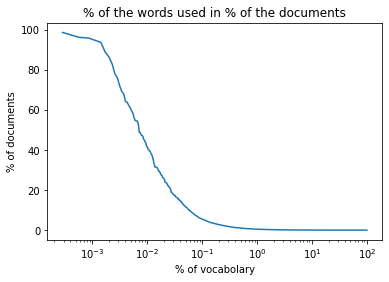

In [6]:
# What % of the reviews use what % of the vocab
vocab_size = len(cnt2)
sample_size = len(train_set)

y = [c/sample_size * 100 for (w, c) in cnt2.most_common()]
x = [c/vocab_size * 100 for c in range(1, vocab_size+1)]
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(x, y)
ax.set_title("% of the words used in % of the documents")
ax.set_xscale('log')
ax.set_xlabel("% of vocabolary")
ax.set_ylabel("% of documents")

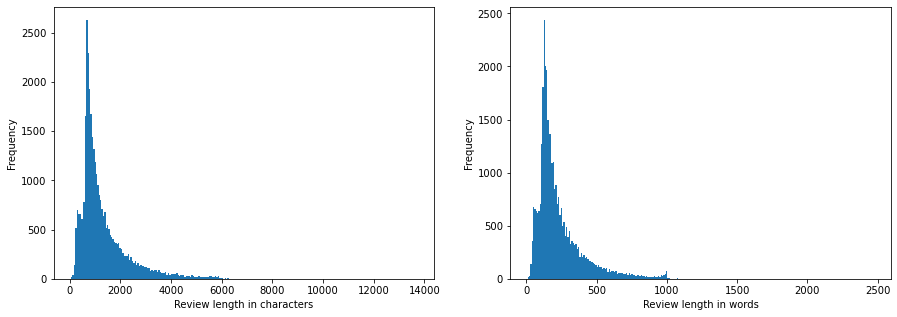

In [16]:
# Length distribution of the reviews
train_set['rev_lens_raw'] = train_set['review'].str.len()
train_set['rev_lens_words'] = train_set['review'].str.split().apply(len)
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].hist(train_set['rev_lens_raw'], bins='auto')
ax[0].set_xlabel("Review length in characters")
ax[0].set_ylabel("Frequency")
ax[1].hist(train_set['rev_lens_words'], bins='auto')
ax[1].set_xlabel("Review length in words")
ax[1].set_ylabel("Frequency")

plt.show()

In [8]:
# Shortest reviews
train_set.nsmallest(10, 'rev_lens_words')['review'].values

array(['I hope this group of film-makers never re-unites.',
       "I wouldn't rent this one even on dollar rental night.",
       'Brilliant and moving performances by Tom Courtenay and Peter Finch.',
       'This movie is terrible but it has some good effects.',
       "You'd better choose Paul Verhoeven's even if you have watched it.",
       'Ming The Merciless does a little Bardwork and a movie most foul!',
       'Adrian Pasdar is excellent is this film. He makes a fascinating woman.',
       'Long, boring, blasphemous. Never have I been so glad to see ending credits roll.',
       'This is a great movie. Too bad it is not available on home video.',
       'Comment this movie is impossible. Is terrible, very improbable, bad interpretation e direction. Not look!!!!!'],
      dtype=object)

In [17]:
# Drop reviews that are very long
#train_set = train_set.loc[train_set['rev_lens_word'] < 1800]
#train_set.reset_index(inplace=True, drop=True)


### 1.4 Preprocessing and vectorization

#### 1.4.1 TextPreprocessor class

In [37]:
# I think to put this into own .PY file and import from there
class TextPreprocessor():
    def __init__(self):
        import nltk
        import re
        import string
        
        nltk.download('stopwords')
        nltk.download('wordnet')
        from nltk.corpus import stopwords
        ", ".join(stopwords.words('english'))
        from nltk.stem.wordnet import WordNetLemmatizer 
        
        self.stop_words = set(stopwords.words('english'))
        
        self.punctuation = string.punctuation
        
        self.emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                u"\U00002702-\U000027B0"
                                u"\U000024C2-\U0001F251"
                                "]+", flags=re.UNICODE)
        
        # src : https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py
        self.emoticons = {
            u":‑\)":"Happy face or smiley",
            u":\)":"Happy face or smiley",
            u":-\]":"Happy face or smiley",
            u":\]":"Happy face or smiley",
            u":-3":"Happy face smiley",
            u":3":"Happy face smiley",
            u":->":"Happy face smiley",
            u":>":"Happy face smiley",
            u"8-\)":"Happy face smiley",
            u":o\)":"Happy face smiley",
            u":-\}":"Happy face smiley",
            u":\}":"Happy face smiley",
            u":-\)":"Happy face smiley",
            u":c\)":"Happy face smiley",
            u":\^\)":"Happy face smiley",
            u"=\]":"Happy face smiley",
            u"=\)":"Happy face smiley"
        }
        
        self.url_pattern = re.compile(r'https?://\S+|www\.\S+')
        self.html_pattern = re.compile('<.*?>')

    def lower_case(self, text):
        return str.lower(text)
    
    def remove_punctuation(self, text):
        return text.translate(str.maketrans('', '', self.punctuation))
    
    def remove_stopwords(self, text):
        return " ".join([word for word in text.split() if word not in self.stop_words])
    
    def remove_words(self, text, freq_words):
        return " ".join([word for word in text.split() if word not in freq_words])
    
    def remove_emoji(self, text):
        # src: https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
        return self.emoji_pattern.sub(r'', text)
    
    
    def remove_emoticons(self, text):
        import re
        # src : https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py
        emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in self.emoticons) + u')')
        return emoticon_pattern.sub(r'', text)
    
    def convert_emoticons(self, text):
        # src : https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py
        for emot in self.emoticons:
            text = re.sub(u'('+emot+')', "_".join(self.emoticons[emot].replace(",","").split()), text)
        return text
    
    def lemmatization(self, text):
        lemmatizer = WordNetLemmatizer()
        tokens = word_tokenize(text)
        for i in ['v','n','a']:
            tokens = [lemmatizer.lemmatize(word, i) for word in tokens]
        return " ".join(tokens)
    
    def expand_contractions(self, text):
        text = re.sub(r"i'm", " i am ", text)
        text = re.sub(r" im ", " i am ", text)
        text = re.sub(r"\: p", "", text)
        text = re.sub(r" ive ", " i have ", text)
        text = re.sub(r" he's ", " he is ", text)
        text = re.sub(r" she's ", " she is ", text)
        text = re.sub(r" that's ", " that is ", text)
        text = re.sub(r" what's ", " what is ", text)
        text = re.sub(r" where's ", " where is ", text)
        text = re.sub(r" haven't ", " have not ", text)
        text = re.sub(r" ur ", " you are ", text)
        text = re.sub(r"\'ll", " will", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r" won't ", " will not ", text)
        text = re.sub(r" wouldn't ", " would not ", text)
        text = re.sub(r" can't ", " cannot ", text)
        text = re.sub(r" couldn't ", " could not ", text)
        text = re.sub(r" don't ", " do not ", text)
        text = re.sub(r" didn't ", " did not ", text)
        text = re.sub(r" doesn't ", " does not ", text)
        text = re.sub(r" isn't ", " is not ", text)
        text = re.sub(r" it's ", " it is ", text)
        text = re.sub(r" who's ", " who is ", text)
        text = re.sub(r" there's ", " there is ", text)
        text = re.sub(r" weren't ", " were not ", text)
        text = re.sub(r" wasn't ", " was not ", text)
        text = re.sub(r" ok ", " okay ", text)
        text = re.sub(r" you're ", " you are ", text)
        text = re.sub(r" c'mon ", " come on ", text)
        text = re.sub(r"\'s", " s", text)
        return text
    
    def remove_numbers(self, text):
        text = re.sub(r'[0-9]', '', text)
        return text
    
    def remove_html_tags(self, text):
        return self.html_pattern.sub(r'', text)
    
    def remove_urls(self, text):
        return self.url_pattern.sub(r'', text)
    
    def process_text_vectorized(self, text):
        text = self.lower_case(text)
        text = self.remove_html_tags(text)
        text = self.remove_numbers(text)
        text = self.remove_urls(text)
        text = self.expand_contractions(text)
        text = self.remove_emoji(text)
        text = self.remove_punctuation(text)
        text = self.lemmatization(text)
        text = self.remove_stopwords(text)
        return text
    
    def preprocess_2(self, corpus, max_df, min_df, n_freq_words = 10, n_rare_words = 10):
        
        vecpreprop = np.vectorize(self.process_text_vectorized)
        
        arr1 = vecpreprop(corpus)
        
        from collections import Counter
        cnt = Counter()
        cnt2 = Counter()
        for text in corpus:
            # Counting the words
            for word in text.split():
                cnt[word] += 1
            # Counting in how many reviews the word appears
            for word in set(text.split()):
                cnt2[word] += 1


        # Removing most frequent words
        freq_words = set([w for (w, wc) in cnt.most_common(n_freq_words)])
        rem_freq_words = np.vectorize(self.remove_words)
        arr2 = rem_freq_words(arr1, freq_words)

        # Removing rarest words
        rare_words = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
        
        rem_rare_words = np.vectorize(self.remove_words)
        arr3 = rem_rare_words(arr2, rare_words)

        # Remove words used in >90% and <5% of the reviews
        curb_max_amount = len(corpus) * max_df
        curb_min_amount = len(corpus) * min_df

        curb_words = set([w for (w, wc) in cnt2.most_common() if wc > curb_max_amount or wc < curb_min_amount])
        print(len(cnt2))
        print(len(curb_words))
        rem_curb_words = np.vectorize(self.remove_words)
        arr4 = rem_curb_words(arr3, curb_words)
        
        return arr4

        
        
    
    # preprocessing IMDB reviews
    def preprocess_imdb_reviews(self, df, max_df, min_df, n_freq_words = 10, n_rare_words = 10):
        df['processed'] = df['review'].apply(lambda text: self.lower_case(text))
        df['processed'] = df['processed'].apply(lambda text: self.remove_html_tags(text))
        df['processed'] = df['processed'].apply(lambda text: self.remove_numbers(text))
        df['processed'] = df['processed'].apply(lambda text: self.remove_urls(text))
        df['processed'] = df['processed'].apply(lambda text: self.expand_contractions(text))
        df['processed'] = df['processed'].apply(lambda text: self.remove_emoji(text))
        df['processed'] = df['processed'].apply(lambda text: self.remove_punctuation(text))

        df['processed'] = df['processed'].apply(lambda text: self.lemmatization(text))
        df['processed'] = df['processed'].apply(lambda text: self.remove_stopwords(text))


        from collections import Counter
        cnt = Counter()
        cnt2 = Counter()
        for text in df['processed'].values:
            # Counting the words
#             for word in text.split():
#                 cnt[word] += 1
            # Counting in how many reviews the word appears
            for word in set(text.split()):
                cnt2[word] += 1


        # Removing most frequent words
#         freq_words = set([w for (w, wc) in cnt.most_common(n_freq_words)])
        
#         df['processed'] = df['processed'].apply(lambda text: self.remove_words(text, freq_words))

#         # Removing rarest words
#         rare_words = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
#         df['processed'] = df['processed'].apply(lambda text: self.remove_words(text, rare_words))

        # Remove words used in >90% and <5% of the reviews
        curb_max_amount = len(df) * max_df
        curb_min_amount = len(df) * min_df
        curb_words = set([w for (w, wc) in cnt2.most_common() if wc > curb_max_amount or wc < curb_min_amount])
        df['processed'] = df['processed'].apply(lambda text: self.remove_words(text, curb_words))
        
        # Other words to remove
        rem_words = ["□", "▢", "■", "\x96", "st", "nd", "rd", "th"]
        df['processed'] = df['processed'].apply(lambda text: self.remove_words(text, rem_words))

        return df, cnt2


#### 1.4.2 TF IDF Vectorizer class

In [38]:
# TF-IDF VECTORIZER CLASS
import math
from collections import Counter
import numpy as np
from nltk import FreqDist

class TfIdfVectorizer:
    def __init__(self, df):
        self._idfs = self.prepare_idfs(df)
        self._vocab = self.prepare_vocab(df)
    
    @property
    def idfs(self):
        return self._idfs
    
    @idfs.setter
    def idfs(self, idfs):
        self._idfs = idfs
    
    @property
    def vocab(self):
        return self._vocab
    
    @vocab.setter
    def vocab(self, vocab):
        self._vocab = vocab
    
    # Prepare and return vocab out of corpus
    def prepare_vocab(self, df):
        # Prepare the vocab
        self.vocab = set(" ".join(df['processed'].values).split())
        self.vocab = dict.fromkeys(self.vocab, 0)
        self.vocab.update((k, i) for i, k in enumerate(self.vocab))
        return self.vocab
    
    # Prepare and return idfs out of corpus
    def prepare_idfs(self, df):
        # Counting how many reviews a word appears ins
        cnt = Counter()
        for text in df["processed"].values:
            for word in set(text.split()):
                cnt[word] += 1
        # Preparing the IDF vector
        size = len(df)
        self.idfs = dict()
        for w, c in cnt.items():
            self.idfs[w] = math.log(size / (1 + c))
        return self.idfs


    # TF-IDF vectorize a single text, returning an np.array
    def tf_idf_vectorize(self, text):
        freq_dist = FreqDist(text.split())
        vector = np.zeros(len(self.vocab))
        for w, c in freq_dist.items():
            if w in self.vocab:
                vector[self.vocab[w]] = c * self.idfs[w]
        return vector


    # One hot encode labels
    def one_hot_encode(self, label, nr_of_labels):
        arr = np.zeros(nr_of_labels, dtype=int)
        arr[label] = 1
        return arr

    # Vectorize all in the dataset
    def tf_idf_vectorize_all(self, df):
        vectors = np.array(df['processed'].apply(lambda text: self.tf_idf_vectorize(text)).values.tolist())
        return vectors
    
    # Turn all labels into one hot encoded arrays
    def one_hot_encode_all(self, df, nr_of_labels):
        vector = np.array(df['label'].apply(lambda label: self.one_hot_encode(label, nr_of_labels)).values.tolist())
        return vector


    

#### 1.4.3 Preprocessing

In [39]:
#Using the preprocessor
preprocessor = TextPreprocessor()
train_set_processed, cnt1 = preprocessor.preprocess_imdb_reviews(train_set, 0.85, 0.0005)
test_set_processed, cnt2 = preprocessor.preprocess_imdb_reviews(test_set, 0.85, 0.0005)
valid_set_processed, cnt3 = preprocessor.preprocess_imdb_reviews(valid_set, 0.85, 0.0005)

train_set_processed

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abdka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abdka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,review,rate,label,rev_lens_raw,rev_lens_words,processed
0,I can't for the life of me remember why--I mus...,1,0,2370,431,life remember must free ticket saw movie theat...
1,What I wouldn't do to give this film a re-writ...,4,0,910,157,would give film rewrite extra disappoint due g...
2,"Well, the Sci-Fi channel keeps churning these ...",2,0,710,120,well scifi channel keep churn turkey seem get ...
3,1st watched 6/18/2009  2 out of 10 (Dir- Pete...,2,0,1448,264,watch dir pete weird psychotic movie girl test...
4,I recall seeing this movie as a kid. I don't r...,10,1,522,107,recall see movie kid recall saw must around ye...
...,...,...,...,...,...,...
34995,This is the last of four swashbucklers from Fr...,7,1,4436,721,last four france schedule view christmas seaso...
34996,The easiest way to describe this movie is as a...,3,0,2171,384,easy way describe movie satire target satire q...
34997,What a ridiculous waste of time and money!!!! ...,1,0,742,136,ridiculous waste time money movie big loser ye...
34998,I saw this back in '94 when it was finally rel...,4,0,606,108,saw back finally release apparently picture th...


#### 1.4.4 Checking preprocessed data

In [40]:
# Data exploration
# Most common words

from collections import Counter
cnt = Counter()
cnt2 = Counter()
for text in train_set_processed["processed"].values:
    # Counting the words
    for word in text.split():
        cnt[word] += 1
    # Counting in how many reviews the word appears
    for word in set(text.split()):
        cnt2[word] += 1

Most common 20 counted by appearance in nr of reviews:  [('movie', 22411), ('film', 20510), ('one', 19663), ('make', 17703), ('like', 16998), ('see', 16926), ('good', 16352), ('get', 14864), ('time', 13671), ('would', 13272), ('watch', 12601), ('go', 12363), ('even', 11707), ('think', 11388), ('character', 11383), ('story', 10745), ('really', 10538), ('bad', 10468), ('much', 9697), ('say', 9418), ('look', 9410), ('well', 9401), ('could', 9380), ('great', 9321), ('know', 9248), ('act', 9211), ('give', 9140), ('scene', 9043), ('end', 9029), ('also', 8730), ('take', 8725), ('way', 8668), ('come', 8666), ('people', 8580), ('first', 8553), ('thing', 8280), ('show', 8202), ('find', 8153), ('play', 7844), ('love', 7718), ('seem', 7207), ('want', 7086), ('many', 7018), ('plot', 7003), ('work', 6965), ('never', 6943), ('actor', 6839), ('try', 6680), ('two', 6660), ('best', 6658), ('little', 6628), ('year', 6609), ('ever', 6566), ('still', 6063), ('life', 5942), ('something', 5579), ('feel', 548

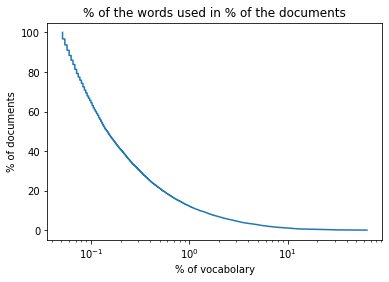

In [41]:
print("Most common 20 counted by appearance in nr of reviews: ", cnt2.most_common(1000))
print("\nMost common 20 counted by word count total: ", cnt.most_common(10))

#print("Most common 50 counted by appearance in nr of reviews: ", cnt1.most_common(50))

vocab_size = len(cnt2)
sample_size = len(train_set)

x = [c/sample_size * 100 for (w, c) in cnt2.most_common()]
y = [c/vocab_size * 100 for c in range(1, vocab_size+1)]

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(x, y)
ax.set_title("% of the words used in % of the documents")
ax.set_xscale('log')
ax.set_xlabel("% of vocabolary")
ax.set_ylabel("% of documents")
plt.show()

In [44]:
train_set_processed.sample(10)

,review,rate,label,rev_lens_raw,rev_lens_words,processed
28788,This was obviously the worst movie ever made.....,1,0,497,83,obviously bad movie ever star role movie would...
7859,Joe Don Baker is one of a handful of actors wh...,8,1,1316,254,joe baker one handful actor often good materia...
16616,This movie was absolutely pathetic. A pitiful ...,2,0,702,125,movie absolutely pathetic pitiful screenplay l...
11902,I saw this movie on the film festival of Rotte...,3,0,2174,369,saw movie film festival jan follow discussion ...
22796,"There isn't much to say about this film, it is...",1,0,549,102,much say film act dialog way far away even dec...
12925,This is one of the best episodes of Doctor Who...,10,1,692,122,one best episode doctor ever conversion unit m...
6747,The first episode of 'Man to Man with Dean Lea...,9,1,820,153,first episode man man dean air least scratch e...
3031,This is one of the best made movies from 2002....,9,1,1746,319,one best make movie maybe best movie look best...
32244,"... but the keyword here is ""usually."" I have ...",4,0,781,138,usually know adore movie everyone think dumb w...
10713,The way this story played out and the interact...,7,1,205,36,way story play interaction lead character may ...


#### 1.4.5 Vectorizing data sets using TF-IDF vectors

In [45]:
# Get the IDF values and VOCAB vector
vectorizer = TfIdfVectorizer(train_set_processed)
idfs = vectorizer.idfs
vocab = vectorizer.vocab

In [46]:
# Vectorizing train set and test set
X_train = vectorizer.tf_idf_vectorize_all(train_set_processed)

X_test = vectorizer.tf_idf_vectorize_all(test_set_processed)

X_valid = vectorizer.tf_idf_vectorize_all(valid_set_processed)

Y_train = train_set_processed['label'].to_numpy()

Y_test = test_set_processed['label'].to_numpy()

Y_valid = valid_set_processed['label'].to_numpy()

In [48]:
# Check if labels fit
index = random.randint(0, len(train_set))
print(Y_train[index])
train_set.loc[index, 'label']

1


1

## 2. Set up genetic algorithm


### 2.1 Classifier
There are a lot of classifiers. I haven't any experience in most of them, just a little familiar with Neural Network thus this is what I did choose.

The acitecture:
len(vector) input Relu() --> 64 nodes --> softmax() --> output

In [49]:
class Classifier:
    def __init__(self, idfs, vocab):
        self.idfs = idfs
        self.vocab = vocab
        self.ws_1 = 0
        self.ws_2 = 0
        self.ws_3 = 0
        self.ws_4 = 0
        self.np_predictor = np.vectorize(lambda vec: self.predict(vec))
        self.hn_1 = 0
        self.hn_2 = 0
        self.hn_3 = 0
        self.in_vector = 0

    # Initializing weights
    def init_weights(self):
        self.ws_1 = np.random.rand(self.in_vector, self.hn_1) - 0.5
        self.ws_2 = np.random.rand(self.hn_1, self.hn_2) - 0.5
        self.ws_3 = np.random.rand(self.hn_2, self.hn_3) - 0.5
        self.ws_4 = np.random.rand(self.hn_3, 2) - 0.5
        return self.ws_1, self.ws_2, self.ws_3, self.ws_4
        
    def set_weights(self, ws_1, ws_2, ws_3, ws_4):
        self.ws_1 = ws_1
        self.ws_2 = ws_2
        self.ws_3 = ws_3
        self.ws_4 = ws_4
    
    def set_hidden_nodes(self, in_vector, hn_1, hn_2, hn_3):
        self.hn_1 = hn_1
        self.hn_2 = hn_2
        self.hn_3 = hn_3
        self.in_vector = in_vector

    def relu(self, x):
        return (x > 0) * x
    
    def relu_grad(self, x):
        return x > 0
    
    def sigmoid(self, x):
        from scipy import special
        return special.expit(x)
    
    def sigmoid_grad(self, x):
        return self.sigmoid(x)*(1 - self.sigmoid(x))
    
    def softmax(self, x):
        import numpy as np
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
        
    def train_with_SGD(self, epochs, lr, x, y):
        error_list = list()
        mse_list = list()
        
        for n in range(epochs):
            for i in range(x.shape[0]):
                l_in = x[i:i+1]
                l_o, l_4, l_3, l_2, l_1, s_1 = self.predict(l_in, True)           
                
                delta_2 = l_2 - y[i]
                delta_1 = delta_2.dot(self.ws_2.T) * self.relu_grad(l_1)
                
                self.ws_2 -= lr * (l_1.T.reshape(self.hn_1,1).dot(delta_2))
                self.ws_1 -= lr * (l_in.T.reshape(x.shape[1],1).dot(delta_1))

                error = delta_2**2
                    
                error_list.append(error[0][0])
            
            mse_list.append(sum(error_list) / x.shape[0])
            error_list = list()
        
        cel, output, acc = self.predict_whole_set(x, y)
        
        return mse_list, cel, output, acc
                

    def cross_entropy(self, p, y):
        import numpy as np
        return (-np.nan_to_num(np.eye(2)[y]*np.log(p))).mean() * 2
    
    def predict(self, x, get_all=False):
        #forward pass/prediction
        layer_1 = self.relu(x.dot(self.ws_1))
        layer_2 = self.relu(layer_1.dot(self.ws_2))
        layer_3 = self.relu(layer_2.dot(self.ws_3))
        layer_4 = layer_3.dot(self.ws_4)
        layer_out = self.softmax(layer_4)
        if get_all:
            return layer_out, layer_4, layer_3, layer_2, layer_1
        else:
            return layer_out
    
    def get_accuracy(self, y, p):
        acc = np.sum((y == np.argmax(p, axis=1))) / len(y)
        return acc
    
    
    
    def predict_whole_set(self, x, y, get_acc = True):
        output = np.apply_along_axis(self.predict, 1, x)
        cel = self.cross_entropy(output, y)
        if get_acc:
            acc = self.get_accuracy(y, output)
        if get_acc:
            acc = self.get_accuracy(y, output)
            return cel, output, acc
        else:
            return cel, output
    

        

#### PyTorch test

In [50]:
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim

In [51]:
# Training function

def training(num_epochs, model, optimizer, criterion, train_loader, valid_loader, vocab_length):
    results = list()
    accuracies = list()
    valid_results = list()
    valid_accuracies = list()

    #model.float()
    for ep in range(num_epochs):
        running_loss = 0
        valid_loss = 0
        total = 0
        correct = 0
        total_valid = 0
        correct_valid = 0
        model.train() # Set model into training mode
        for batch in train_loader:
            # We extract the images and labels from the batch
            vector = batch[:, :vocab_length]
            labels = batch[:, vocab_length]
            labels = torch.tensor(labels, dtype=torch.long)
            # This will prevent the gradient descents from the previous batches to accumulate. Without this the weight will get updated with the sum of
            # all previos gradient descents, instead of the gradient descents on the current batch.
            optimizer.zero_grad() 
            output = model(vector) # prediction / output from the model

            loss = criterion(output, labels)  # We calculate the loss here
            loss.backward() # Computes the derivative of the loss using backpropagation.
            optimizer.step() # We update the weights

            running_loss += loss.item() # Sum the loss here
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        else:
            results.append(running_loss / len(train_loader))  # We append the mean loss into a list
            accuracies.append(correct / total)
    
        # Validation part
        model.eval()
        with torch.no_grad(): # This will prevent calculation of gradient descents
            for batch in valid_loader:
                vector = batch[:, :vocab_length]
                labels = batch[:, vocab_length]
                valid_output = model(vector) # Prediciton
                loss = criterion(valid_output, labels.long()) # Calculation of loss
                valid_loss += loss.item() # Sum the loss

                _, predicted = torch.max(valid_output.data, 1)
                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()
            else:
                valid_results.append(valid_loss / len(valid_loader)) # Here we calculate the mean loss
                valid_accuracies.append(correct_valid / total_valid)
    return results, accuracies, valid_results, valid_accuracies

In [65]:
learning_rate = 0.00005

num_epochs = 8

criterion = nn.CrossEntropyLoss()



In [66]:
train_torch = np.c_[X_train, Y_train]

train_torch = torch.from_numpy(train_torch)
train_torch = torch.tensor(train_torch, dtype=torch.float)

valid_torch = np.c_[X_valid, Y_valid]

valid_torch = torch.from_numpy(valid_torch)
valid_torch = torch.tensor(valid_torch, dtype=torch.float)

<ipython-input-66-b33fb47361d0>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_torch = torch.tensor(train_torch, dtype=torch.float)
<ipython-input-66-b33fb47361d0>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_torch = torch.tensor(valid_torch, dtype=torch.float)


In [67]:
train_loader = torch.utils.data.DataLoader(train_torch, batch_size=1, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_torch, batch_size=1, shuffle=True)

In [68]:
model = nn.Sequential(nn.Linear(len(vocab), 16),
                      nn.ReLU(),
                      nn.Linear(16, 8),
                      nn.ReLU(),
                      nn.Linear(8, 8),
                      nn.ReLU(),
                      nn.Linear(8,2)
                     )

optimizer = optim.SGD(model.parameters(), lr = learning_rate)


        
        
    

In [69]:
sgd_results, accuracies, sgd_results_valid, accuracies_valid = training(num_epochs, model, optimizer, criterion, train_loader, valid_loader, len(vocab))

<ipython-input-51-14579e24792d>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


In [70]:
len(sgd_results)

8

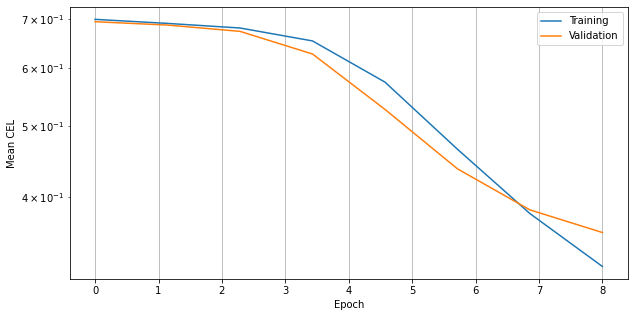

8

In [71]:
x_axis = np.linspace(0, num_epochs, num_epochs)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_axis, sgd_results, label='Training')
ax.plot(x_axis, sgd_results_valid, label='Validation')
ax.set_ylabel("Mean CEL")
ax.set_xlabel("Epoch")
ax.grid()

ax.set_yscale('log')
#ax.set_xscale('log')

plt.legend()

plt.show()
len(sgd_results)

In [72]:
print(sgd_results[0])
print(sgd_results[-1])
print(accuracies[0])
print(accuracies[-1])
print(sgd_results_valid[0])
print(sgd_results_valid[-1])
print(accuracies_valid[0])
print(accuracies_valid[-1])
len(train_loader)

0.6984349294594356
0.32111552852796554
0.5
0.9110571428571429
0.6932744906425476
0.3572738931387057
0.5
0.8728


35000

In [73]:
# Initialize classifier
classifier = Classifier(idfs, vocab)

In [104]:
classifier.set_hidden_nodes(len(vocab), 16, 8, 8)
classifier.init_weights()
cel_pre, output, acc_pre = classifier.predict_whole_set(X_valid, Y_valid)
print(cel_pre)
print(acc_pre)

print(sum(np.argmax(output, axis=1)))

1.0076227196861143
0.492
2566


### 2.2 Chromosome
It's just some weights that'll be used for classification

In [113]:
class Chromosome:
    # x_pos and y_pos are the features of our chromosome
    def __init__(self, ws_1, ws_2, ws_3, ws_4):
        self._fitness = 0
        self._ws_1 = ws_1
        self._ws_2 = ws_2
        self._ws_3 = ws_3
        self._ws_4 = ws_4
    
    # Getters and setters
    @property
    def ws_1(self):
        return self._ws_1
    
    @ws_1.setter
    def ws_1(self, value):
        self._ws_1 = value
    
    @property
    def ws_2(self):
        return self._ws_2
    
    @ws_2.setter
    def ws_2(self, value):
        self._ws_2 = value
    
    @property
    def ws_3(self):
        return self._ws_3
    
    @ws_3.setter
    def ws_3(self, value):
        self._ws_3 = value
    
    @property
    def ws_4(self):
        return self._ws_4
    
    @ws_4.setter
    def ws_4(self, value):
        self._ws_4 = value
    
    @property
    def fitness(self):
        return self._fitness
    
    @fitness.setter
    def fitness(self, value):
        self._fitness = value
    
    def __lt__(self, other):
        return self.fitness < other.fitness

    def __le__(self, other):
        return self.fitness <= other.fitness
    
    def __eq__(self, other):
        return self.fitness == other.fitness
    
    def __ne__(self, other):
        return self.fitness != other.fitness
    
    def __ge__(self, other):
        return self.fitness >= other.fitness
    
    def __gt__(self, other):
        return self.fitness > other.fitness
    
    def assign_fitness(self, classifier, x, y):
        import math
        classifier.set_weights(self.ws_1, self.ws_2, self.ws_3, self.ws_4)
        loss, _, acc = classifier.predict_whole_set(x, y, True)
        self.fitness = acc #0 if loss <= 0 or loss == float('inf') else -math.log(1 / loss)
    
    # produce a new offspring from 2 parents
    def crossover(self, other):
        r = 2
        
        min_mat_1 = np.minimum(self.ws_1, other.ws_1)
        max_mat_1 = np.maximum(self.ws_1, other.ws_1)
        min_mat_2 = np.minimum(self.ws_2, other.ws_2)
        max_mat_2 = np.maximum(self.ws_2, other.ws_2)
        min_mat_3 = np.minimum(self.ws_3, other.ws_3)
        max_mat_3 = np.maximum(self.ws_3, other.ws_3)
        min_mat_4 = np.minimum(self.ws_4, other.ws_4)
        max_mat_4 = np.maximum(self.ws_4, other.ws_4)
        
        ws_1 = np.random.uniform(min_mat_1-r, max_mat_1+r)
        ws_2 = np.random.uniform(min_mat_2-r, max_mat_2+r)
        ws_3 = np.random.uniform(min_mat_3-r, max_mat_3+r) 
        ws_4 = np.random.uniform(min_mat_4-r, max_mat_4+r) 
        
        offspring = Chromosome(ws_1, ws_2, ws_3, ws_4)
        return offspring

    # mutate the individual
    def mutate(self):
        np.random.shuffle(self.ws_1)
        self.ws_1 = self.ws_1 + np.random.uniform(-5, 5, size=self.ws_1.shape)
        np.random.shuffle(self.ws_2)
        self.ws_2 = self.ws_2 + np.random.uniform(-5, 5, size=self.ws_2.shape)
        np.random.shuffle(self.ws_3)
        self.ws_3 = self.ws_3 + np.random.uniform(-5, 5, size=self.ws_3.shape)
        np.random.shuffle(self.ws_4)
        self.ws_4 = self.ws_4 + np.random.uniform(-5, 5, size=self.ws_4.shape)
        return
    

    



### 2.3 Genetic Algorithm Engine

Here I have divided the population in two: elite and population.
Elite contains the population with highest fitness. This is to make sure if we find a very fit chromosome we don't lose it again because of cross overs or mutations.

And we make the mutations first. We make mutations on the least fit chromosomes. Mutations are here are nothing more than just randomly generating a new chromosome.




In [114]:
class GAEngine:
    def __init__(self, classifier):
        self._population = []
        self._generations = 0
        self._classifier = classifier
        self.elite = []
        self.nr_of_elites = 0
        self.to_mutate = []

    def make_initial_population(self, population_size):       
        for i in range(population_size):
            ws_1, ws_2, ws_3, ws_4 = self.classifier.init_weights()
            self.population.append(Chromosome(ws_1, ws_2, ws_3, ws_4))

        
    @property
    def generations(self):
        return self._generations
    
    @generations.setter
    def generations(self, g):
        self._generations = g
    
    @property
    def population(self):
        return self._population
    
    @population.setter
    def population(self, p):
        self._population = p
    
    @property
    def classifier(self):
        return self._classifier
    
    @classifier.setter
    def classifier(self, cl):
        self._classifier = cl
    
    # selection code goes here...
    def do_crossover(self, elite_crossover_rate):
        import random
        population_size = len(self.population)
        
                
        # Here we combine elitism selection with roulette wheel
        # We carry some of the most fit over to the next generation.
        # We do cross over with both the elite and other population
        # Then we use roulette wheel because we want diversity too.
        # We want diversity because it's hard to predict optimal weights
        
        no_of_elite_crossovers = int(elite_crossover_rate * population_size)
        
        other_offspring = population_size - no_of_elite_crossovers

        new_generation = list()
        
        # Offsprings from the elite
        for i in range(no_of_elite_crossovers):
            parent1, parent2 = random.choices(self.elite, k=2)
            offspring = parent1.crossover(parent2)
            new_generation.append(offspring)
        
        # Weighted random choice
        fitness_values = [x.fitness**2 for x in self.population]
        
        # Offsprings from other population
        for i in range(other_offspring):
            parent1, parent2 = random.choices(self.population, weights=fitness_values, k=2)
            offspring = parent1.crossover(parent2)
            new_generation.append(offspring)
        
        # The population is the new generation
        self.population = new_generation
        return
    
    
    def do_mutation(self, no_of_mutation, x, y):
        for i in range(no_of_mutation):
            self.population[-i-1].mutate()
            self.population[-i-1].assign_fitness(self.classifier, x, y)
    
    
    # fitness calculation goes here...
    def assign_fitness(self, x, y):
        for ch in self.population:
            ch.assign_fitness(self.classifier, x, y)
        self.population = sorted(self.population, reverse=True)
        self.update_elite()
        return
    
    def get_population(self):
        return self.population
    
    def update_elite(self):
        if len(self.elite) == 0:
            self.elite = self.population[-self.nr_of_elites:]
            self.elite = sorted(self.elite, reverse=True)
            return
        i = 0
        j = 0
        while i < self.nr_of_elites and j < len(self.population):
            if self.elite[i] < self.population[j]:
                self.elite[i] = self.population[j]
                i += 1
                j += 1
            else:
                i += 1
        
        self.elite = sorted(self.elite, reverse=True)

    
    def get_best_chromosome(self):
        return max(self.elite)
    
    # TRAINING ROUTINE
    def training_routine(self, init_population, nr_of_generations, 
                        nr_of_mutation, nr_of_elites, elite_crossover_rate, x, y):
        self.make_initial_population(init_population)
        self.generations = nr_of_generations
        self.nr_of_elites = nr_of_elites
        
        cels = list()


        for i in range(self.generations):
            self.assign_fitness(x, y)
            self.update_elite()
            cels.append(self.elite[-1].fitness)
            
            self.do_mutation(nr_of_mutation, x, y)
            self.update_elite()
            
            self.do_crossover(elite_crossover_rate)
            
            

        # Assign fitness last time before getting the best chromosome
        self.assign_fitness(x, y)
        self.update_elite()
        cels.append(self.get_best_chromosome().fitness)
        return self.get_best_chromosome(), cels

### 2.4 Optimizing classifier with Genetic Algorithm

In [139]:
%%time
# Here I run the GA engine
classifier = Classifier(idfs, vocab)
classifier.set_hidden_nodes(len(vocab), 16, 8, 8)

ga = GAEngine(classifier)

init_population = 20
nr_of_generations = 10 
nr_of_mutation = 10
nr_of_elites = 10
elite_crossover_rate = 0.

ch, cels = ga.training_routine(init_population, 
                               nr_of_generations, 
                               nr_of_mutation,
                               nr_of_elites, 
                               elite_crossover_rate, 
                               X_valid, Y_valid)
cels


<ipython-input-49-64b0c61d8be3>:82: RuntimeWarning: divide by zero encountered in log
  return (-np.nan_to_num(np.eye(2)[y]*np.log(p))).mean() * 2
<ipython-input-49-64b0c61d8be3>:82: RuntimeWarning: invalid value encountered in multiply
  return (-np.nan_to_num(np.eye(2)[y]*np.log(p))).mean() * 2


Wall time: 2min 57s


[0.4842666666666667,
 0.49933333333333335,
 0.5010666666666667,
 0.49466666666666664,
 0.49866666666666665,
 0.5,
 0.4998666666666667,
 0.4948,
 0.5002666666666666,
 0.5006666666666667,
 0.5282666666666667]

In [140]:
# for i in range(3):
#     print("pop", ga.population[i].fitness)
#     print("elite", ga.elite[i].fitness)

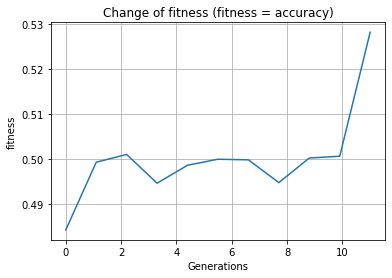

In [141]:
# Plotting increase of fitness in training
x = np.linspace(0, len(cels), len(cels))
fig, ax = plt.subplots(1, 1)
ax.plot(x, cels, label='fitness')

plt.xlabel("Generations")
plt.ylabel("fitness")
plt.title("Change of fitness (fitness = accuracy)")

plt.grid()
plt.show()


## 3. Validation

In [142]:
classifier.set_weights(ch.ws_1, ch.ws_2, ch.ws_3, ch.ws_4)
cel_post, output_post, acc_post = classifier.predict_whole_set(X_test, Y_test)

<ipython-input-49-64b0c61d8be3>:82: RuntimeWarning: divide by zero encountered in log
  return (-np.nan_to_num(np.eye(2)[y]*np.log(p))).mean() * 2
<ipython-input-49-64b0c61d8be3>:82: RuntimeWarning: invalid value encountered in multiply
  return (-np.nan_to_num(np.eye(2)[y]*np.log(p))).mean() * 2
C:\Users\abdka\anaconda3\envs\testing\lib\site-packages\numpy\core\_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


In [143]:
print("Accuracy before training: ", acc_pre)
print("Accuracy after training: ", acc_post)
print("CEL before training", cel_pre)
print("CEL after training", cel_post)

Accuracy before training:  0.492
Accuracy after training:  0.5222666666666667
CEL before training 1.0076227196861143
CEL after training inf


In [ ]:
print(sum(np.argmax(output_post, axis=1)))

## Draft codes

In [103]:
arr1 = [1,2,3]
arr2 = [4,5]
arr3 = [7,8, 9,10]

nparr3 = np.array([arr1, arr2, arr3])
nparr = np.array([[1,2,3],[3,4,5],[4,5,6]])
nparr2 = np.array([[1, 3],[3, 4],[3,4],[3,2],[2,1],[9,3]])

np.argmax(nparr2, axis=1)
nparr2

<ipython-input-103-b4c45037dd8a>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nparr3 = np.array([arr1, arr2, arr3])


array([[1, 3],
       [3, 4],
       [3, 4],
       [3, 2],
       [2, 1],
       [9, 3]])

In [ ]:
np.random.rand(3, 2)

In [ ]:
starr = np.array(["thIs is Good", "this is BAD", "this is NOT so good"])

class test:
    def __init__(self):
        return
    
    def func(self, x, y):
        x = x + y
        return str.lower(x)
    

t = test()

vecfunc = np.vectorize(t.func)

vecfunc(starr, "aaa")

In [ ]:
np.char.split(starr)

In [ ]:
yy = [0, 1, 1]
zz = [[0.5, 0.9],[0.5, 0.9], [0.5, 0.9]]
np.eye(2)[yy]
#-np.nan_to_num(yy*np.log(zz))

In [ ]:
-np.log(0.9)

In [ ]:
x = "aaa"
y = x + "bb"
y

In [ ]:
%%time
" ".join(train_set['reviews'].values)

In [459]:
processor

NameError: name 'processor' is not defined

In [828]:
np.exp(1)

2.718281828459045

In [61]:
# create dummy data for training
x_values = [i for i in range(11)]
x_train = np.array(x_values, dtype=np.float32)
x_train = x_train.reshape(-1, 1)

y_values = [2*i + 1 for i in x_values]
y_train = np.array(y_values, dtype=np.float32)
y_train = y_train.reshape(-1, 1)

x_train

array([[ 0.],
       [ 1.],
       [ 2.],
       [ 3.],
       [ 4.],
       [ 5.],
       [ 6.],
       [ 7.],
       [ 8.],
       [ 9.],
       [10.]], dtype=float32)